# Tutorial 1: The Basics with Simple Calcium

The system of calcium's ground state excited to its first excited state with an on-resonance laser is one of the simplest systems to model as there is only a ground S-state and an excited P-state with no hyperfine structure. We can verify results already published by [Murray 2003](https://iopscience.iop.org/article/10.1088/0953-4075/36/24/011/meta) by using the `LASED` package. In this paper the transition between the ground S-state and the first excited singlet P-state is modelled with the laser on-resonance and 200 MHz & 500 MHz detuned from resonance.

First, we'll set up the states. A diagram of the system we are going to model is seen below. The ground S-state is represented by one sub-state lebelled as $|1\rangle$ and the excited P-state is represented by three sub-states labelled as $|2\rangle$, $|3\rangle$, and $|4\rangle$. 

The numbers indicate the labelling I have given them. It is convention to label the sub-states in your system by labelling the lowest in energy state first. The sub-state with the lowest $m$ value is labelled as $|1\rangle$ and then the 2nd lowest $m$ value as $|2\rangle$ etc. until you run out of sub-states. Then, the next highest in energy state is labelled.

The wavelength of the difference in energy between these two states is also shown as 422.8 nm. 

![Calcium](LevelDiagrams/Calcium.jpg)

Now, we'll import the `LASED` library and a plotting library. I use `Plotly` to plot all the figures here but any plotting library can be used.

In [1]:
import LASED as las
from IPython.display import Image
import plotly.graph_objects as go  # For plotting
import time  # NOT NEEDED: For seeing how quickly the time evolution is calculated
import numpy as np

## Setting up the System

With LASED you can declare atomic sub-states using the `State` object. These states are used to declare a `LaserAtomSystem` which can then be used to calculate the time evolution of the system.

First, we must declare the system's variables: wavelength of the transition, lifetime of the excited state, isospin, etc. 

**Note**: LASED has a timescale of nanoseconds so all times will be input in nanoseconds. If I want a lifetime of 4.6e-9 s then I have to input 4.6 into my `LaserAtomSystem` object.

In [2]:
wavelength_ca = 422.8e-9  # wavelength of Ca transition in metres
tau_ca = 4.6 # lifetime in nanoseconds
I_ca = 0  # Isospin of calcium

Create the `State` objects by providing the `label` of the sub-state with the convention as above. **The system may not be modelled correctly if you do not stick to this labelling convention**.

Each sub-state must have a relative angular frequency `w` associated with it. This angular frequency is related to the energy as usual $E = \hbar w$. All frequencies should be in gigaradians per second. The energies are _relative_ so you just have to set a zero point and then all other sub-states have energies relative to this point. I have set the zero-point as the energy of the ground sub-state.

Each sub-state must be labelled with its corresponding quantum numbers: orbital angular momentum `L`, spin `S`, projection of total angular momentum `m`. The isospin `I` is assumed to be zero if not specified. The total angular momentum (without isospin) can be specified with keyword `J` and is calculated as `J=L+S` if not specified. The total angular momentum with isospin can be specified with keyword `F` and if not specifed is calculated as `F=J+I`.

To create the ground or excited state you must insert each sub-state in an ordered list starting with the smallest labelled state to the highest labelled state. 

In [3]:
# Calculate angular frequency of the transition
w_e = las.angularFreq(wavelength_ca)  # Converted to angular frequency in Grad/s

# Create states
s1 = las.State(label = 1, w = 0, m = 0, L = 0, S = 0)
s2 = las.State(label = 2, w = w_e, m = -1, L = 1, S = 0)
s3 = las.State(label = 3, w = w_e, m = 0, L = 1, S = 0)
s4 = las.State(label = 4, w = w_e, m = 1, L = 1, S = 0)
print(s3)

# Create ground and excited states list
G_ca = [s1]
E_ca = [s2, s3, s4]

State(label = 3, w = 4455183.460995396, m = 0, L = 1, J = 1, I = 0, F = 1)


Declare the laser parameters. The intensity of the laser `laser_intensity` must be in units of mW/mm$^2$. 

The polarisation of the laser is defined by keyword `Q` and is either right-hand circular ($\sigma^+$) with a +1, left-hand circular ($\sigma^-$) with a -1, and linear ($\pi$) polarisation with the polarisation axis defined along the axis with a 0 (angle of polarisation of zero degrees). `Q` is defined as a list of any of these three values. If `Q` is 0 then it is defined that the linear polarisation is aligned with the x-axis (if the z-axis is the quantisation axis). This is known as the collision frame in scattering experiments.

The `detuning` of the laser away from resonance can be specified as well. If no detuning is given then the laser is assumed to be on-resonance i.e. `detuning = 0`

**Note on using more than one polarisation**: If more than one value is in the list then the laser is defined as having simulataneous polarisations of the same laser acting upon the atom. This can be possible if working in the natural frame when the laser is travelling along the direction of the quantisation axis and the polarisation is linear in the collision frame. When working in this natural frame `Q = [-1, 1]`. You must normalise the Rabi frequencies if you do this by a normalisation constant by giving the `LaserAtomSystem` an attribute called `rabi_scaling`. In this case of two simultaneous Rabi frequencies, the correct time evolution would be scaled by `1/np.sqrt(2)`. If `n` simultaneous polarisations are used then it must be scaled by `1/np.sqrt(n)`. You must also apply the `rabi_factors` attribute as the simultaneous combination of LHC and RHC Rabi frequencies is only equal to a linear exciation if the total Rabi frequency is $1/\sqrt(2)(\Omega^{-1}-\Omega^{+1})$ so the RHC Rabi frequency must be multiplied by -1. This is achieved by setting the `rabi_factors` attribute to `rabi_factors = [1, -1]` if using a `Q` as stated above. Each element of `Q` is multiplied by the corresponding element in `rabi_factors`.

In [4]:
intensity_ca = 100 # mW/mm^-2
Q_ca = [0]
detuning = 0.2*2*np.pi  # detuning here is 200 MHz in Grad/s
detuning2 = 0.5*2*np.pi  # detuning here is 500 MHz in Grad/s

The `time` over which the simulation run must be sepcified. It must be specified with a list with every discrete time step (in nanoseconds) in it. Numpy's `linspace` is handy for this task.

In [5]:
# Simulation parameters
start_time = 0
stop_time = 50 # in ns
time_steps = 501
time_ca = np.linspace(start_time, stop_time, time_steps)

Create a `LaserAtomSystem` object by using the variables stated above. Three system's are created here for different detunings. 

In [6]:
calcium_system = las.LaserAtomSystem(E_ca, G_ca, tau_ca, Q_ca, wavelength_ca, 
                                 laser_intensity = intensity_ca)
calcium_system200MHzdetuned = las.LaserAtomSystem(E_ca, G_ca, tau_ca, Q_ca, wavelength_ca, 
                                 laser_intensity = intensity_ca)
calcium_system500MHzdetuned = las.LaserAtomSystem(E_ca, G_ca, tau_ca, Q_ca, wavelength_ca, 
                                 laser_intensity = intensity_ca)

## Time Evolution of the System

Perform a `timeEvolution` of each system. The `pretty_print_eq` keyword is used here to print out the system's equations of motion using `Sympy`. There are many other keywords which can be used with `timeEvolution` including averaging over the doppler profile of the atoms, averaging the Gaussian laser beam profile, and numerically printing the equations.

I have just timed this piece of code to see how long it takes.

**Note**: An initial condition density matrix can be specified at t = 0 to evolve. If none is stated then **all ground sub-states are populated equally with no coherence between sub-states**.

In [7]:
tic = time.perf_counter()
calcium_system.timeEvolution(time_ca,
                             pretty_print_eq = True)
calcium_system200MHzdetuned.timeEvolution(time_ca,
                             detuning = detuning)
calcium_system500MHzdetuned.timeEvolution(time_ca,
                             detuning = detuning2)
toc = time.perf_counter()
print(f"The code finished in {toc-tic:0.4f} seconds")

Populating ground states equally as the initial condition.


Populating ground states equally as the initial condition.
Populating ground states equally as the initial condition.
The code finished in 6.0851 seconds


## Saving and Plotting

We can save the data to a .csv file and now plot the data generated to see the time evolution.

To save to csv use the `saveToCSV("filename")` function on your `LaserAtomSystem` object. 

In [8]:
calcium_system.saveToCSV("SavedData/SimpleCalciumNoDetuning.csv")
calcium_system200MHzdetuned.saveToCSV("SavedData/SimpleCalcium200MHzDetuning.csv")
calcium_system500MHzdetuned.saveToCSV("SavedData/SimpleCalcium200MHzDetuning.csv")

Now, we can plot the evolution of Calcium with no detuning, 200 MHz detuning, and 500 MHz detuning.

To access the density matrix elements over the time evolution use the function `Rho_t(e, g)` on the `LaserAtomSystem`. This gives a list of the element $\rho_{eg}$ for each interval in `time`. Each element of the density matrix is `complex` so the real part is taken by using the `abs()` function. 

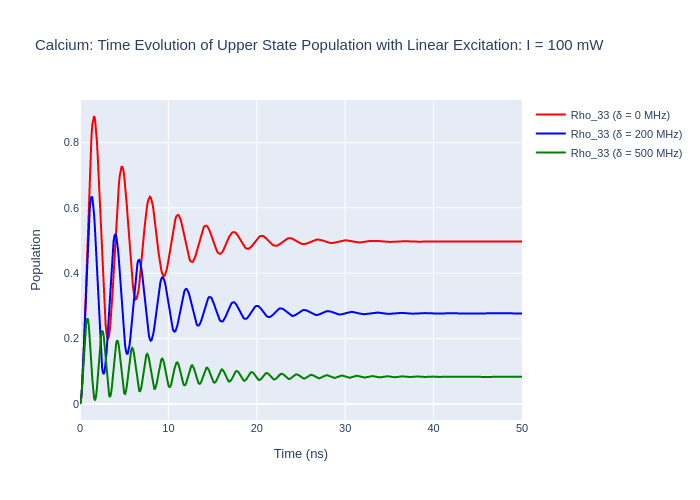

In [9]:
rho_33 = [abs(rho) for rho in calcium_system.Rho_t(s3, s3)]
rho_33_200MHzdetuned = [abs(rho) for rho in calcium_system200MHzdetuned.Rho_t(s3, s3)]
rho_33_500MHzdetuned = [abs(rho) for rho in calcium_system500MHzdetuned.Rho_t(s3, s3)]

fig_ca = go.Figure()
fig_ca.add_trace(go.Scatter(x = time_ca,
                                 y = rho_33,
                                 mode = 'lines',
                                    name = "Rho_33 (δ = 0 MHz)",
                                    marker = dict(
                                color = 'red',
                                symbol = 'circle',
                            )))
fig_ca.add_trace(go.Scatter(x = time_ca,
                                 y = rho_33_200MHzdetuned,
                                 mode = 'lines',
                                    name = "Rho_33 (δ = 200 MHz)",
                                    marker = dict(
                                color = 'blue',
                                symbol = 'circle',
                            )))
fig_ca.add_trace(go.Scatter(x = time_ca,
                                 y = rho_33_500MHzdetuned,
                                 mode = 'lines',
                                    name = "Rho_33 (δ = 500 MHz)",
                                    marker = dict(
                                color = 'green',
                                symbol = 'circle',
                            )))

fig_ca.update_layout(title = "Calcium: Time Evolution of Upper State Population with Linear Excitation: I = 100 mW",
                 xaxis_title = "Time (ns)",
                 yaxis_title = "Population",
                font = dict(
                    size = 11))

fig_ca.write_image("SavedPlots/tutorial1-ca.png")
Image("SavedPlots/tutorial1-ca.png")

## Elliptical Polarisation

To excite an atomic system with ellipticaly polarised light use the relation that elliptically polarisaed light can be composed of right-hand circular (RHC) $\sigma^+$ and left-hand circular (LHC) $\sigma^-$ light in varying weights. So, elliptical light can be described as:

$$
\epsilon = \frac{1}{\sqrt{L^2+R^2}}(L\sigma^-+R\sigma^+)
$$

where $R$ and $L$ are weights denoting how elliptically polarised the light is in either right or left-handed direction. If $R = L$ then the light is just linearly polarised. The ratio of L to R determines how elliptically polarised the light is.

The Rabi frequency for elliptically polarisation follows from the expression above and is the superposition of the Rabi frequency for RHC and LHC light with differing weights:

$$
\Omega^{\epsilon}=\frac{1}{\sqrt{L^2+R^2}}(L\Omega^{-1}-R\Omega^{+1})
$$

To encode this in `LASED` the polarisation key word `Q = [1, -1]` with `rabi_factors = [L, R]` and `rabi_scaling = 1/np.sqrt(L*L+R*R)` for normalisation. With this description of the `LaserAtomSystem` the laser beam's direction of travel is down the quantisation axis. As an exmaple, the simple calcium system will be modelled with different weights: one system with more a more LHC ellipse and the other with a more RHC ellipse.

For the first system, use values of L = 0.75 and R = 0.25.

Populating ground states equally as the initial condition.


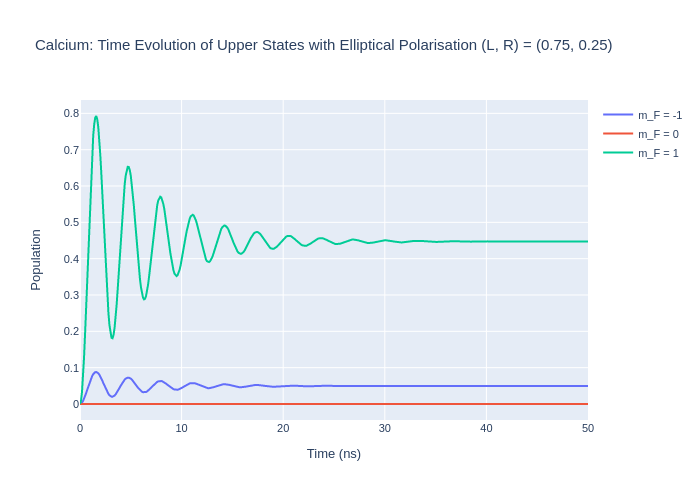

In [10]:
# Declare polarisation and Rabi parameters
Q_ellipse = [1, -1]
rabi_factors_lhc = [0.75, 0.25]
rabi_scaling_lhc = 1/np.sqrt(0.75*0.75+0.25*0.25)

# Create laser-atom system
calcium_system_lhc = las.LaserAtomSystem(E_ca, G_ca, tau_ca, Q_ellipse, wavelength_ca, 
                                 laser_intensity = intensity_ca, rabi_scaling = rabi_scaling_lhc,
                                    rabi_factors = rabi_factors_lhc)

# Time eveolve system
calcium_system_lhc.timeEvolution(time_ca)

# Plot all excited states
rho_e = [[abs(rho) for rho in calcium_system_lhc.Rho_t(s, s)] for s in E_ca]
fig_ca_lhc = go.Figure()
for i, rho in enumerate(rho_e):
    fig_ca_lhc.add_trace(go.Scatter(x = time_ca, 
                                y = rho,
                                name = f"m_F = {E_ca[i].m}",
                               mode = 'lines'))

fig_ca_lhc.update_layout(title = "Calcium: Time Evolution of Upper States with Elliptical Polarisation (L, R) = (0.75, 0.25)",
                 xaxis_title = "Time (ns)",
                 yaxis_title = "Population",
                font = dict(
                    size = 11))
fig_ca_lhc.write_image(f"SavedPlots/tutorial1-ellipselhc.png")
Image(f"SavedPlots/tutorial1-ellipselhc.png")

Now, model a system with a slightly more RHC elliptcal polarisation.

Populating ground states equally as the initial condition.


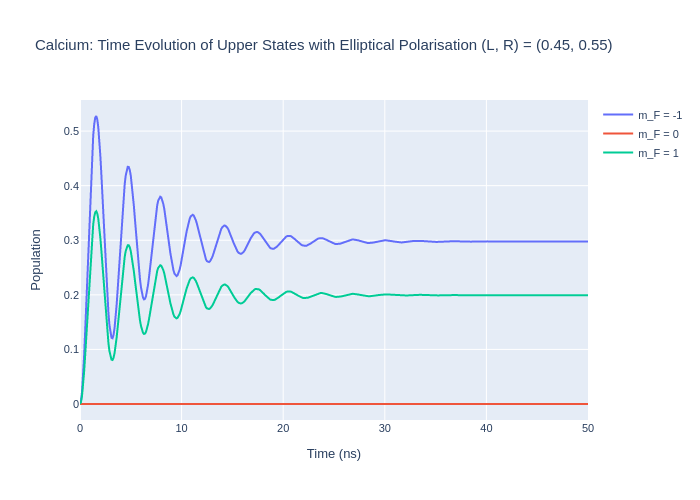

In [11]:
# Rabi parameters
rabi_factors_rhc = [0.45, 0.55]
rabi_scaling_rhc = 1/np.sqrt(0.45*0.45+0.55*0.55)

# Create laser-atom system
calcium_system_rhc = las.LaserAtomSystem(E_ca, G_ca, tau_ca, Q_ellipse, wavelength_ca, 
                                 laser_intensity = intensity_ca, rabi_scaling = rabi_scaling_rhc,
                                    rabi_factors = rabi_factors_rhc)

# Time eveolve system
calcium_system_rhc.timeEvolution(time_ca)

# Plot all excited states
rho_e = [[abs(rho) for rho in calcium_system_rhc.Rho_t(s, s)] for s in E_ca]
fig_ca_rhc = go.Figure()
for i, rho in enumerate(rho_e):
    fig_ca_rhc.add_trace(go.Scatter(x = time_ca, 
                                y = rho,
                                name = f"m_F = {E_ca[i].m}",
                               mode = 'lines'))

fig_ca_rhc.update_layout(title = "Calcium: Time Evolution of Upper States with Elliptical Polarisation (L, R) = (0.45, 0.55)",
                 xaxis_title = "Time (ns)",
                 yaxis_title = "Population",
                font = dict(
                    size = 11))
fig_ca_rhc.write_image(f"SavedPlots/tutorial1-ellipserhc.png")
Image(f"SavedPlots/tutorial1-ellipserhc.png")

If L = R then this would be the same as a linear polarisation in the reference frame where the laser beam is travelling down the quantisation axis. This is called the natural frame. To put this in the collision frame, where the polarisation vector is along the quantisation axis, then rotations must be used.

## Setting the Initial Conditions

There are two ways to specify the initial condition $\rho_0$ in `LASED`: one way is to set the entire density matrix for the system in one function using the object's variable `rho_0` directly and the other way is to set the initial condition for each sub-state equally using the function `setRho_0(s1,s2, value)` where `s1` and `s2` are state objects specifying the density matrix element which is initialised to `value`. In the example below calcium will be initialised with two different conditions.

The sum of the populations of the density matrix must be equal to 1 and the coherences must be set so that $\rho_{eg} = \rho_{ge}^*$.

In [12]:
calcium_system_init1 = las.LaserAtomSystem(E_ca, G_ca, tau_ca, Q_ca, wavelength_ca, 
                                 laser_intensity = intensity_ca)

# Set the populations of the ground state 1 and excited state 3 to 0.5 each with no coherences between them
calcium_system_init1.setRho_0(s1, s1, 0.2)
calcium_system_init1.setRho_0(s3, s3, 0.8)
# Perform time evolution
calcium_system_init1.timeEvolution(time_ca)
# Plot the excited population
rho_33_init1 = [abs(rho) for rho in calcium_system_init1.Rho_t(s3, s3)]

Now, we are going to build a flattened density matrix `rho_0` and input this straight into the system. To build the initial density matrix we must input the density matrix elements in the correct position. To do this, use the `index(e, g, n)` function to find the index which the density matrix element will sit in a flattened density matrix.

In [13]:
calcium_system_init2 = las.LaserAtomSystem(E_ca, G_ca, tau_ca, Q_ca, wavelength_ca, 
                                 laser_intensity = intensity_ca)

# Set out the density matrix elements to be initialised
rho_11_t0 = 0.2
rho_33_t0 = 0.8
rho_13_t0 = 0.5+0.5j  # These coherences can be complex! 
rho_31_t0 = 0.5-0.5j

# Now build a flattened density matrix with these conditions
n = 4 # nunber of sub-states in the Calcium system
rho_0 = np.zeros((n*n, 1), dtype = complex) # Make an empty 2D array with only one column
rho_0[las.index(s1, s1, n), 0] = rho_11_t0
rho_0[las.index(s3, s3, n), 0] = rho_33_t0
rho_0[las.index(s1, s3, n), 0] = rho_13_t0
rho_0[las.index(s3, s1, n), 0] = rho_31_t0
print(rho_0)

[[0.2+0.j ]
 [0. +0.j ]
 [0.5+0.5j]
 [0. +0.j ]
 [0. +0.j ]
 [0. +0.j ]
 [0. +0.j ]
 [0. +0.j ]
 [0.5-0.5j]
 [0. +0.j ]
 [0.8+0.j ]
 [0. +0.j ]
 [0. +0.j ]
 [0. +0.j ]
 [0. +0.j ]
 [0. +0.j ]]


Above is the correct form of `rho_0` we want to input. We can directly input this into the `LaserAtomSystem` object by using the key identifier `LaserAtomSystem.rho_0`.

**Note**: be careful here as there is no safety conditions which have to be met to input this variable. Make sure that this is the correct size and format of the flattened density matrix.

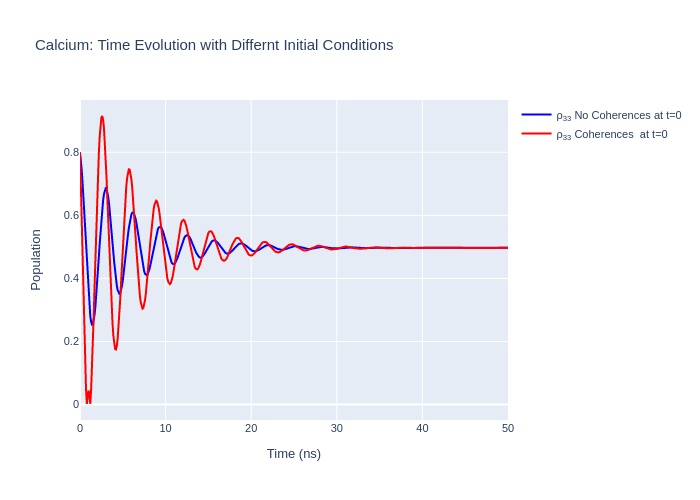

In [14]:
calcium_system_init2.rho_0 = rho_0  # Set the variable directly

# Perform time evolution
calcium_system_init2.timeEvolution(time_ca)
# Plot the excited population
rho_33_init2 = [abs(rho) for rho in calcium_system_init2.Rho_t(s3, s3)]
fig_ca_init = go.Figure(go.Scatter(x = time_ca,
                                 y = rho_33_init1,
                                 mode = 'lines',
                                    name = "ρ<sub>33</sub> No Coherences at t=0",
                                    marker = dict(
                                color = 'blue',
                                symbol = 'cross'
                            )))
fig_ca_init.add_trace(go.Scatter(x = time_ca,
                                 y = rho_33_init2,
                                 mode = 'lines',
                                    name = "ρ<sub>33</sub> Coherences\n at t=0",
                                    marker = dict(
                                color = 'red',
                                symbol = 'circle'
                            )))
fig_ca_init.update_layout(title = f"Calcium: Time Evolution with Differnt Initial Conditions",
                 xaxis_title = "Time (ns)",
                 yaxis_title = "Population",
                font = dict(
                    size = 11))

fig_ca_init.write_image("SavedPlots/tutorial1-ca-init.png")
Image("SavedPlots/tutorial1-ca-init.png")

## Gaussian Laser Beam Profiles

A laser beam usually does not have a flat beam profile (known as a "top-hat" distribution) in intensity. As the beam has spatial variation in intensity the atoms being excited experience a non-uniform time evolution. To model the effects of the beam profile the beam can be split up into regions of approximate uniform intensity and each spatial portion of the beam is used to time-evolve a part of the system being illuminated. Then, each part of the system is summed together and normalised which results in the entire system being modelled.

`LASED` supports the modelling of a Gaussian TEM$_{00}$ laser beam profile. The 2D standard deviation of the Gaussian must be declared with keyword `r_sigma` when performing the `timeEvolution()` of the `LaserAtomSystem`. The number of portions which the beam is split into must be chosen as well. This is declared with the keyword `n_beam_averaging` when using `timeEvolution()`. The Gaussian averaging is applied to the time evolution of the system only if it is declared that `beam_profile_averaging = True` inside the `timeEvolution()` function. If these are left out then a "top-hat" distribution of laser intensity is assumed. Also, to use the Gaussian avergaing over the beam profile, the keyword `laser_power` must be defined in the `LaserAtomSystem`. This is the total power which the laser delivers as opposed to the intensity over a mm$^2$.

Below, the laser parameters are declared for this system and the simple calcium system is modelled using these parameters.

**Note**: If using this averaging the model will loop over the time evolution with the number defined in `n_intensity` so the model will be much slower if a larger number is input. The larger number also results in a more accurate representation of the beam profile. Usually, a `n_intensity` of around 50 is enough for most cases.

In [15]:
# Laser parameters
laser_power = 100 # laser intensity in mW
r_sigma = 0.75  # radial distance to 2D standard deviation in mm
n_intensity = 20

calcium_system_gaussian = las.LaserAtomSystem(E_ca, G_ca, tau_ca, Q_ca, wavelength_ca, 
                                 laser_power = laser_power)
calcium_system_gaussian.timeEvolution(time_ca, 
                            r_sigma = r_sigma,
                            n_beam_averaging = n_intensity,
                            beam_profile_averaging = True)
# Plot the excited population
rho_33_gaussian = [abs(rho) for rho in calcium_system_gaussian.Rho_t(s3, s3)]

Populating ground states equally as the initial condition.


Now, we can plot the result and compare to the time evolution when excited with a "top-hat" beam profile.

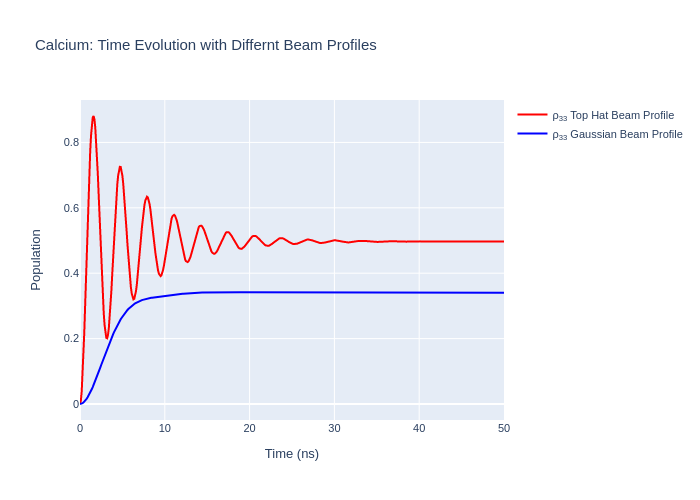

In [16]:
fig_ca_gauss = go.Figure()
fig_ca_gauss.add_trace(go.Scatter(x = time_ca,
                                 y = rho_33,
                                 mode = 'lines',
                                name = "ρ<sub>33</sub> Top Hat Beam Profile",
                                marker = dict(
                                    color = 'red',
                                    symbol = 'circle'
                            )))
fig_ca_gauss.add_trace(go.Scatter(x = time_ca,
                                 y = rho_33_gaussian,
                                 mode = "lines", 
                                 name = "ρ<sub>33</sub> Gaussian Beam Profile",
                                 marker = dict(
                                     color = "blue",
                                     symbol = "x"
                                 )))
fig_ca_gauss.update_layout(title = f"Calcium: Time Evolution with Differnt Beam Profiles",
                 xaxis_title = "Time (ns)",
                 yaxis_title = "Population",
                font = dict(
                    size = 11))
fig_ca_gauss.write_image("SavedPlots/tutorial1-ca-gaussian.png")
Image("SavedPlots/tutorial1-ca-gaussian.png")

### Doppler Detuning from the Atomic Velocity Profile

When using `LASED` the atoms being excited are usually defined as being stationary unless specified. If the atoms are not stationary and have some velocity with respect to the laser beam then the frequency of the laser is detuned from resonance due to the fixed velocity. In experiments an atomic beam is sometimes used to provide the atoms to some interaction region where the laser-excitation takes place. If a velocity component is in (or opposite to) the direction of the laser beam then detuning occurs. The velocity component can be specified using the `atomic_velocity` keyword in the `timeEvolution()`. This is specified in units of m/s in the direction of the laser beam. If the direction is opposite to this then the `atomic_velocity` is negative. 

Detuning can also occur due to the Maxwell-Boltzmann distribution of atomic velocities. This results in a Gaussian detuning profile. This can be modelled by splitting the detuning due to the velocity distribution of atoms into uniform sections and time-evolving the system with these uniform detunings and then summing up the time evolution for each detuning and normalising. The detuning due to this Doppler broadening can be modelled in `LASED` by defining a `doppler_width` in Grad/s in `timeEvolution()` and a list with all the detunings to be used for the averaging process called `doppler_detunings`. The more elements in `doppler_detunings` the more the time evolution of the system is calculated and the more time it will take to model the system.

In [17]:
# Model the atomic velocity introducing a Doppler shift
atomic_velocity = 50  # Velocity component of atoms in direction of laser beam in m/s
# Set up the system
calcium_system_atomic_velocity = las.LaserAtomSystem(E_ca, G_ca, tau_ca, Q_ca, wavelength_ca, 
                                 laser_intensity = intensity_ca)
# Perform time evolution
calcium_system_atomic_velocity.timeEvolution(time_ca, atomic_velocity = atomic_velocity)
# Plot the excited state population
rho_33_atomic_velocity = [abs(rho) for rho in calcium_system_atomic_velocity.Rho_t(s3, s3)]

Populating ground states equally as the initial condition.


Detuning can also occur due to the Maxwell-Boltzmann distribution of atomic velocities. This results in a Gaussian detuning profile. This can be modelled by splitting the detuning due to the velocity distribution of atoms into uniform sections and time-evolving the system with these uniform detunings and then summing up the time evolution for each detuning and normalising. The detuning due to this Doppler broadening can be modelled in `LASED` by defining a `doppler_width` in Grad/s in `timeEvolution()` and a list with all the detunings to be used for the averaging process called `doppler_detunings`. The more elements in `doppler_detunings` the more the time evolution of the system is calculated and the more time it will take to model the system. Then, use the statement `doppler_averaging = True` in the `timeEvolution()` function.

In [18]:
# Declare the Doppler profile parameters
doppler_width = 0.3*2*np.pi # doppler width here is 300 MHz but have to convert it into Grad/s so multiply by 2*PI and scale
delta_upper = 3*doppler_width
delta_lower = -3*doppler_width
doppler_steps = 30
doppler_detunings = np.linspace(delta_lower, delta_upper, doppler_steps)
# Set up the system
calcium_system_doppler = las.LaserAtomSystem(E_ca, G_ca, tau_ca, Q_ca, wavelength_ca, 
                                 laser_intensity = intensity_ca)
# Perform time evolution
calcium_system_doppler.timeEvolution(time_ca,   
                            doppler_width = doppler_width,
                            doppler_detunings = doppler_detunings,
                            doppler_averaging = True)
# Plot the excited state population
rho_33_doppler = [abs(rho) for rho in calcium_system_doppler.Rho_t(s3, s3)]

Populating ground states equally as the initial condition.


Plot the results to compare.

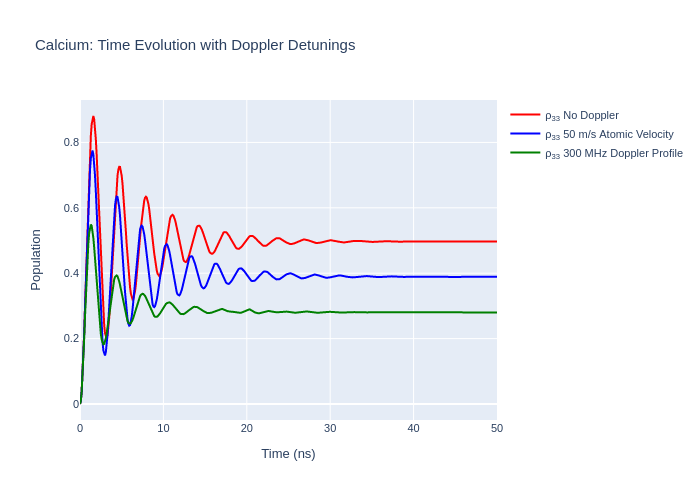

In [19]:
fig_ca_doppler = go.Figure()
fig_ca_doppler.add_trace(go.Scatter(x = time_ca,
                                 y = rho_33,
                                 mode = 'lines',
                                name = "ρ<sub>33</sub> No Doppler",
                                marker = dict(
                                    color = 'red',
                                    symbol = 'circle'
                            )))
fig_ca_doppler.add_trace(go.Scatter(x = time_ca,
                                 y = rho_33_atomic_velocity,
                                 mode = "lines", 
                                 name = "ρ<sub>33</sub> 50 m/s Atomic Velocity",
                                 marker = dict(
                                     color = "blue",
                                     symbol = "x"
                                 )))
fig_ca_doppler.add_trace(go.Scatter(x = time_ca,
                                 y = rho_33_doppler,
                                 mode = "lines", 
                                 name = "ρ<sub>33</sub> 300 MHz Doppler Profile",
                                 marker = dict(
                                     color = "green",
                                     symbol = "x"
                                 )))
fig_ca_doppler.update_layout(title = f"Calcium: Time Evolution with Doppler Detunings",
                 xaxis_title = "Time (ns)",
                 yaxis_title = "Population",
                font = dict(
                    size = 11))
fig_ca_doppler.write_image("SavedPlots/tutorial1-ca-doppler.png")
Image("SavedPlots/tutorial1-ca-doppler.png")

## Doppler Detuning and Gaussian Beam Profile

In `LASED` Doppler profile and Gaussian beam averaging can be modelled in the same system.

**Note**: When using _both_ Doppler and Gaussian beam averaging the number of times the system is time evolved will be `n_intensity` multiplied by the number of elements in `doppler_detunings`.

In [20]:
# Set up system
calcium_system_gauss_and_dopp = las.LaserAtomSystem(E_ca, G_ca, tau_ca, Q_ca, wavelength_ca, 
                                 laser_power = laser_power)
# Time evolve the system
calcium_system_gauss_and_dopp.timeEvolution(time_ca, 
                            r_sigma = r_sigma,
                            n_beam_averaging = n_intensity,
                            doppler_width = doppler_width,
                            doppler_detunings = doppler_detunings,
                            doppler_averaging = True,
                            beam_profile_averaging = True)
# Plot the excited state population
rho_33_gauss_and_dopp = [abs(rho) for rho in calcium_system_gauss_and_dopp.Rho_t(s3, s3)]

Populating ground states equally as the initial condition.


Now, plot the results.

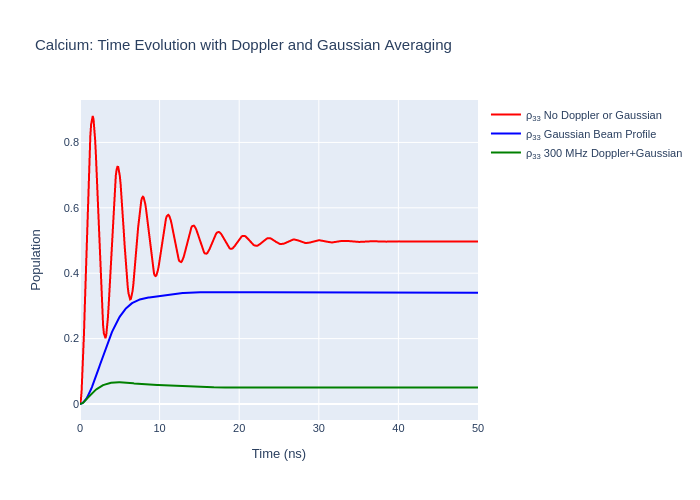

In [21]:
fig_ca_gauss_and_dopp = go.Figure()
fig_ca_gauss_and_dopp.add_trace(go.Scatter(x = time_ca,
                                 y = rho_33,
                                 mode = 'lines',
                                name = "ρ<sub>33</sub> No Doppler or Gaussian",
                                marker = dict(
                                    color = 'red',
                                    symbol = 'circle'
                            )))
fig_ca_gauss_and_dopp.add_trace(go.Scatter(x = time_ca,
                                 y = rho_33_gaussian,
                                 mode = "lines", 
                                 name = "ρ<sub>33</sub> Gaussian Beam Profile",
                                 marker = dict(
                                     color = "blue",
                                     symbol = "x"
                                 )))
fig_ca_gauss_and_dopp.add_trace(go.Scatter(x = time_ca,
                                 y = rho_33_gauss_and_dopp,
                                 mode = "lines", 
                                 name = "ρ<sub>33</sub> 300 MHz Doppler+Gaussian",
                                 marker = dict(
                                     color = "green",
                                     symbol = "x"
                                 )))
fig_ca_gauss_and_dopp.update_layout(title = f"Calcium: Time Evolution with Doppler and Gaussian Averaging",
                 xaxis_title = "Time (ns)",
                 yaxis_title = "Population",
                font = dict(
                    size = 11))
fig_ca_gauss_and_dopp.write_image("SavedPlots/tutorial1-ca-gauss-and-dopp.png")
Image("SavedPlots/tutorial1-ca-gauss-and-dopp.png")

## Exporting the Equations of Motion

`LASED` can print the equations of motion and/or export the equations to a .tex and a .pdf file. Note, that you must have a filename included if you want to export to a .tex file or .pdf file. Use the key idenifier `pretty_print_eq_filename` in `timeEvolution()`.

**Note**: You must have `pdflatex` installed on your system to generate a .pdf file. This is used to convert the .tex file produced to a .pdf file. You can do this on Windows or Mac by installing MiKTeX on your system.

In [22]:
calcium_system_to_print = las.LaserAtomSystem(E_ca, G_ca, tau_ca, Q_ca, wavelength_ca, 
                                 laser_intensity = intensity_ca)
calcium_system_to_print.timeEvolution(time_ca,
                                    pretty_print_eq = True, 
                                    pretty_print_eq_tex = True,  
                                    pretty_print_eq_pdf = True, 
                                    pretty_print_eq_filename = "CalciumSystemEquations")

Populating ground states equally as the initial condition.
